In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import os
import scipy.io as sio
import scipy
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
import sklearn.cluster as cluster
from sklearn.mixture import GMM
from scipy import interpolate
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)


# bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

# Z = bathy.variables['Bathymetry'][:]

# lon = bathy['nav_lon'][...]
# lat = bathy['nav_lat'][...]


bathy = nc.Dataset('/data/ssahu/WCVI_sliced_bathy_NEP36_original.nc')


Z = bathy.variables['Bathymetry'][:]

# y_wcvi_slice = np.array(np.arange(180,350))
# x_wcvi_slice = np.array(np.arange(480,650))

# z_wcvi = Z[y_wcvi_slice, x_wcvi_slice]
lon_wcvi = bathy['nav_lon'][:]#[180:350, 480:650]
lat_wcvi = bathy['nav_lat'][:]#[180:350, 480:650]

z0 = np.ma.masked_values(Z, 0)

In [3]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

sal_mean_august  = np.mean(sal[88:119,...], axis=0)
temp_mean_august = np.mean(sal[88:119,...], axis=0)
spic_mean_august = np.mean(spic[88:119,...], axis=0)
rho_mean_august  = np.mean(rho[88:119,...], axis=0)

In [10]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'


all_surveys = [survey_mat_file_A, survey_mat_file_B, survey_mat_file_D, \
              survey_mat_file_E, survey_mat_file_G]

lon_falkor = []
lat_falkor = []

for survey_file in all_surveys:
    
    mat = scipy.io.loadmat(survey_file)
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    
    lon_falkor = np.append(arr=lon_falkor, values=lon_survey)
    lat_falkor = np.append(arr=lat_falkor, values=lat_survey)
        

/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


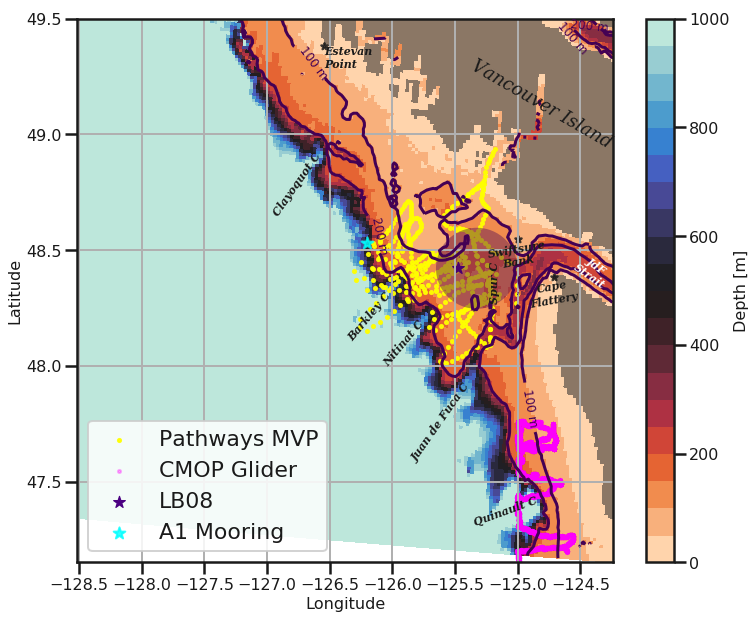

In [11]:
import matplotlib as mpl
# y = np.empty_like(lat_location)
# x = np.empty_like(lat_location)



cmap = plt.cm.get_cmap('icefire_r', 20)
# cmap = cmo.cm.turbid
# cmap = plt.cm.jet
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist[0] = (.8, .8, .8, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)
# cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()

ax.set_aspect(viz_tools.set_aspect(ax, coords='map', lats=lat_wcvi, adjustable='box-forced'))


# ax.relim()
# ax.autoscale_view(True,True,True)
# ax.autoscale_view(scalex=True)
# ax.autoscale(enable=True, axis='both', tight=None)
# bathy_tools.plot_colourmesh(bathy, title = 'WCVI Subset', fig_size=(9, 9), axis_limits=None, colour_map='winter_r', bins=15, land_colour='burlywood')
# p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=500)


p = ax.pcolormesh(lon_wcvi,lat_wcvi,Z, cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(p, ax=ax)
ax.set_aspect('auto')



CS1 = ax.contour(lon_wcvi, lat_wcvi, Z, np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(1000,1010,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(500,510,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



# aspect = 20
# pad_fraction = 0.001
# divider = make_axes_locatable(ax)
# width = axes_size.AxesY(ax, aspect=1./aspect)
# pad = axes_size.Fraction(pad_fraction, width)
# cax = divider.append_axes("right", size=width, pad=pad)
# cbar = fig.colorbar(p, cax=cax)


# for i in np.arange(lat_location.shape[0]):
#     y[i], x[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
# n = np.empty_like(lat_location)
# m = np.empty_like(lat_location)


# for i in np.arange(lat_location.shape[0]):
#     n[i], m[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

# y = y.astype(int)
# x = x.astype(int)

# n = n.astype(int)
# m = m.astype(int)
# ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.5, label = 'Falkor CTD locations')

ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

lon_W02 = -124.89500
lat_W02 = 48.04167

lon_W01 = -124.82500
lat_W01 = 48.31500



lon_swift = -125.00
lat_swift = 48.55

ax.scatter(lon_swift, lat_swift,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Swiftsure Bank')

# S = ("SwB")
S = ("Swiftsure\nBank")
ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)
# ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 10,
#          va='bottom', wrap=False)


lat_cape = 48.3831
lon_cape = -124.7144

ax.scatter(lon_cape, lat_cape,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Cape Flattery')

CP = ("Cape\nFlattery")
ax.text(lon_cape, lat_cape, CP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)


lat_jdfs = 48.5
lon_jdfs = -124.4

JD = ("JdF\nStrait")
ax.text(lon_jdfs, lat_jdfs, JD, fontsize=11, color = 'white', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = -35,
         va='top', wrap=False)


lat_EP = 49.3835
lon_EP = -126.5447

ax.scatter(lon_EP, lat_EP,  c='k', marker='*',  s=50, alpha=0.8)

EP = ("Estevan\nPoint")
ax.text(lon_EP, lat_EP, EP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 0,
         va='top', wrap=False)


lon_LB08 = -125.4775
lat_LB08 = 48.4217




ax.scatter(lon_falkor[::3], lat_falkor[::3],  c='yellow', marker='o',  s=10, alpha=0.9, label = 'Pathways MVP')

ax.scatter(lon_glider[::50], lat_glider[::50],  c='magenta', marker='o',  s=10, alpha=0.3, label = 'CMOP Glider')

ax.scatter(lon_LB08, lat_LB08,  c='indigo', marker='*',  s=150, linewidths=1.2, alpha=1, label = 'LB08')

lon_A1 = -126.20433
lat_A1 = 48.52958

ax.scatter(lon_A1, lat_A1,  c='cyan',marker='*',  s=150, alpha=0.8, label = 'A1 Mooring')

# ax.scatter(lon_W01, lat_W01, c='cyan', s=150, alpha=0.8, label = 'W01')

# ax.scatter(lon_W02, lat_W02, c='red', s=150, alpha=0.8, label = 'W02')

# ax.scatter(lon_location[:], lat_location[:], c='purple', s=100, alpha=0.3, label = 'Falkor CTD locations')

legend = ax.legend(loc='lower left', fancybox=True, framealpha=0.85)

# ax.set_xlabel('x_index')
# ax.set_ylabel('y_index')
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

# viz_tools.plot_land_mask(ax, bathy)#, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
# cbar = fig.colorbar(p, cax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=16)
ax.tick_params(axis='both',labelsize =16)
cbar.ax.tick_params(labelsize=16) 

# t = ("JdF Canyon")
# ax.text(lon_W01, lat_W01, t, fontsize=11, color = 'darkblue', family='serif', style='italic', ha='left', rotation = 55,
#          va='bottom', wrap=True)

t = ("Juan de Fuca C")
ax.text(-125.79, 47.58, t, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)



d = ("Clayoquot C")
ax.text( -126.9, 48.64, d, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)

C = ("Spur C")
ax.text(-125.14, 48.45, C, fontsize=11, color = 'k',fontweight = 'heavy', family='serif', style='italic', ha='right', rotation = 90,
         va='bottom', wrap=True)

X = ("Barkley C")
ax.text(-126.0, 48.3, X, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)

Y = ("Nitinat C")
ax.text(-125.73, 48.18, Y, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)


A = ("Quinault C")
ax.text(-124.83, 47.4, A, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 20,
         va='bottom', wrap=True)


V = ("Vancouver Island")
ax.text(-124.85, 49.1, V, fontsize=18, color = 'k', family='serif', style='italic', ha='center', rotation = -30,
         va='bottom', wrap=True)

from matplotlib.patches import Circle,Ellipse
from matplotlib.collections import PatchCollection


patches = []
# circle = Circle((lon_LB08, lat_LB08), 0.35)
# circle = plt.Circle((lon_LB08, lat_LB08), 0.2, color='blue')
circle = Ellipse((lon_LB08+0.15, lat_LB08), 0.65, 0.35,
                     angle=0, linewidth=2, fill=False, zorder=2, label = 'Eddy Region')
patches.append(circle)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)

ax.grid()






ax.set_ylim(top=49.5, bottom=47.15136337)
ax.set_xlim(left=-128.51552, right=-124.24068451)

path_to_save = '/home/ssahu/saurav/NEP36_Model_Eval_plots/'
# plt.savefig(path_to_save + 'Domain_edited.png')

In [5]:
# glider_data = pd.read_table('/data/ssahu/CMOP_glider_data/phoebe-2013-7-15_0002013-8-7_2359.csv', \
#                              delim_whitespace=1, parse_dates= True, header = None, skiprows=1)

glider_data = pd.read_table('/data/ssahu/CMOP_glider_data/phoebe-2013-5-8_0002013-6-1_2359.csv', \
                             delim_whitespace=1, parse_dates= True, header = None, skiprows=1)

In [6]:
df_cut = glider_data
columns = ['Time[PST]', 'Oxygen[ml/l]', 'Fluorescence[ug/l]', 'Salinity[PSU]', \
           'Longitude[degree_east]', 'Depth[m]', 'Latitude[degree_north]', 'CDOM[QSDE]', \
           'Backscatter[m^-1 sr^-1]', 'Temperature[C]']
# effective = columns[:7]
df_cut.columns = columns

for i in df_cut.select_dtypes([np.object]).columns[:]:
    
    df_cut[i] = df_cut[i].str.replace(',', '')
    
for i in df_cut.select_dtypes([np.object]).columns[1:]:
    
    df_cut[i] = df_cut[i].str.replace(',', '').astype(np.float)
    
    
df = pd.DataFrame()

df['Time[PST]']              = pd.to_datetime(df_cut.iloc[:,0])
df['Depth[m]']               = df_cut.iloc[:,5]
df['Latitude[degree_north]'] = df_cut.iloc[:,6]
df['Longitude[degree_east]'] = df_cut.iloc[:,4]
df['Temperature[C]']         = df_cut.iloc[:,-1]
df['Salinity[PSU]']          = df_cut.iloc[:,3]

# df = df.set_index('Time[PST]').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')


# df = df.groupby(['Depth[m]']).mean().dropna()

# print(df.groupby(['Latitude[degree_north]', 'Longitude[degree_east]']).groups)



In [8]:
df.head(5)

,Time[PST],Depth[m],Latitude[degree_north],Longitude[degree_east],Temperature[C],Salinity[PSU]
0,2013-05-08 07:46:17,NaN,46.581,-123.946,0.0,NaN
1,2013-05-08 07:51:26,0.0,46.905,-124.106,NaN,NaN
2,2013-05-08 07:51:27,0.0,46.905,-124.106,NaN,NaN
3,2013-05-08 07:51:28,0.0,46.905,-124.106,NaN,NaN
4,2013-05-08 07:51:29,0.0,46.905,-124.106,NaN,NaN


In [9]:
df.shape[0]

758067

In [10]:
lon_glider = df['Longitude[degree_east]']
lat_glider = df['Latitude[degree_north]']


temp_glider = df['Temperature[C]']
sal_glider  = df['Salinity[PSU]']
depth_glider = df['Depth[m]']

pressure_loc = np.empty_like(lon_glider)
SA_loc       = np.empty_like(pressure_loc)
CT_loc       = np.empty_like(pressure_loc)
spic_loc     = np.empty_like(pressure_loc)
rho_loc      = np.empty_like(pressure_loc)

for i in np.arange(df.shape[0]):
    
    depth_loc = depth_glider[i]
    
    pressure_loc[i] = gsw.p_from_z(-depth_loc, lat_glider[i])

    SA_loc[i] = gsw.SA_from_SP(sal_glider[i], pressure_loc[i], lon_glider[i], lat_glider[i])

    CT_loc[i] = gsw.CT_from_pt(sal_glider[i], temp_glider[i])

    spic_loc[i] = gsw.spiciness0(SA_loc[i], CT_loc[i])

    rho_loc[i] = gsw.density.rho(SA_loc[i], CT_loc[i], 0)
 

In [11]:
   
    
df['Potential Density'] = rho_loc
    
df['Spice']             = spic_loc
    

In [12]:
dg  = df.groupby(['Latitude[degree_north]', 'Longitude[degree_east]', 'Depth[m]']).mean().dropna()

In [13]:
dg.head(20)

Temperature[C]  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                   
46.905                 -124.106               0.000           15.73736   
46.908                 -124.740               3.773           10.83700   
                                              3.792           10.83700   
                                              3.841           10.83600   
                                              3.882           10.83800   
                                              3.922           10.83600   
                                              3.943           10.83800   
                                              4.021           10.83600   
                                              4.339           10.83800   
                                              4.516           10.83900   
                                              4.843           10.83900   
                                              5.000           10.83900   
                                              5.144           10.83900   
                                              5.435           10.84200   
                                              5.720           10.84100   
                                              5.895           10.83900   
                                              6.190           10.83600   
                                              6.329           10.83600   
                                              6.467           10.83600   
                                              6.738           10.83800   

                                                        Salinity[PSU]  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                  
46.905                 -124.106               0.000             0.000   
46.908                 -124.740               3.773            31.228   
                                              3.792            31.228   
                                              3.841            31.229   
                                              3.882            31.228   
                                              3.922            31.229   
                                              3.943            31.228   
                                              4.021            31.229   
                                              4.339            31.228   
                                              4.516            31.228   
                                              4.843            31.228   
                                              5.000            31.227   
                                              5.144            31.227   
                                              5.435            31.227   
                                              5.720            31.227   
                                              5.895            31.227   
                                              6.190            31.228   
                                              6.329            31.227   
                                              6.467            31.227   
                                              6.738            31.227   

                                                        Potential Density  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                      
46.905                 -124.106               0.000            998.986029   
46.908                 -124.740               3.773           1023.872481   
                                              3.792           1023.872481   
                                              3.841           1023.873429   
                                              3.882           1023.872308   
                                              3.922           1023.873428   
                                              3.943           1023.872307   
                                              4.021           1023.873426   
                                              4.33

In [14]:


#dg.to_csv('/data/ssahu/CMOP_glider_data/glider_data_may.csv')

In [15]:
dg.index.names

FrozenList(['Latitude[degree_north]', 'Longitude[degree_east]', 'Depth[m]'])

In [19]:
np.array(dg.loc[dg.index[400][0],dg.index[400][1]].index)

array([  4.037,   4.08 ,   4.088,   4.131,   4.221,   4.222,   4.224,
         4.263,   4.366,   4.439,   4.455,   4.529,   4.642,   4.812,
         4.851,   5.078,   5.151,   5.21 ,   5.319,   5.468,   5.61 ,
         5.746,   5.885,   6.055,   6.13 ,   6.244,   6.454,   6.507,
         6.798,   6.947,   7.09 ,   7.124,   7.269,   7.347,   7.384,
         7.527,   7.545,   7.79 ,   7.807,   8.032,   8.047,   8.205,
         8.314,   8.321,   8.511,   8.54 ,   8.548,   8.621,   8.68 ,
         8.706,   8.757,   8.954,   9.061,   9.266,   9.471,   9.624,
         9.758,   9.885,  10.119,  10.369,  10.625,  10.752,  10.961,
        11.157,  11.333,  11.421,  11.517,  11.648,  11.878,  12.1  ,
        12.311,  12.381,  12.441,  12.514,  12.729,  12.991,  13.149,
        13.226,  13.292,  13.347,  13.406,  13.449,  13.499,  13.506])

In [20]:
### Let us make the along-isopycnal spice for three rho 26.3, 26.4 and 26.5 for each of the locations

# dg.loc[46.908,-124.740]

lon_position = np.empty(dg.index.shape[0])
lat_position = np.empty_like(lon_position)

spic_rho_263 = np.empty_like(lat_position)
spic_rho_264 = np.empty_like(lat_position)
spic_rho_265 = np.empty_like(lat_position)

depth_rho_263 = np.empty_like(lat_position)
depth_rho_264 = np.empty_like(lat_position)
depth_rho_265 = np.empty_like(lat_position)

for k in np.arange(dg.index.shape[0]):


    lon_position[k] =  dg.index[k][1]
    lat_position[k] = dg.index[k][0]

    depth_position = np.array(dg.loc[dg.index[k][0],dg.index[k][1]].index)

    rho_position   = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,2] -1000
    spic_position  = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,3] 

    spic_rho_263[k] = np.interp(26.3, rho_position, spic_position)
    depth_rho_263[k] = np.interp(26.3, rho_position, depth_position)
    
    spic_rho_264[k] = np.interp(26.4, rho_position, spic_position)
    depth_rho_264[k] = np.interp(26.4, rho_position, depth_position)
    
    spic_rho_265[k] = np.interp(26.5, rho_position, spic_position)
    depth_rho_265[k] = np.interp(26.5, rho_position, depth_position)
    
    
    
    
    

In [16]:

lon_position = np.empty(dg.index.shape[0])
lat_position = np.empty_like(lon_position)

spic_rho_263 = np.empty_like(lat_position)
spic_rho_264 = np.empty_like(lat_position)
spic_rho_265 = np.empty_like(lat_position)

depth_rho_263 = np.empty_like(lat_position)
depth_rho_264 = np.empty_like(lat_position)
depth_rho_265 = np.empty_like(lat_position)

for k in np.arange(dg.index.shape[0]):
    
    lon_position[k] =  dg.index[k][1]
    lat_position[k] = dg.index[k][0]

    depth_position = np.array(dg.loc[dg.index[k][0],dg.index[k][1]].index)

    rho_position   = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,2] -1000
    spic_position  = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,3] 

    if rho_position.shape[0]>2:

        spic_rho_263[k] = interpolate.interp1d(rho_position, spic_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.3)
        depth_rho_263[k] = interpolate.interp1d(rho_position, depth_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.3)

        spic_rho_264[k] = interpolate.interp1d(rho_position, spic_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.4)
        depth_rho_264[k] = interpolate.interp1d(rho_position, depth_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.4)

        spic_rho_265[k] = interpolate.interp1d(rho_position, spic_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.5)
        depth_rho_265[k] = interpolate.interp1d(rho_position, depth_position, fill_value='extrapolate', \
                                               assume_sorted=False)(26.5)


#     spic_rho_263[k] = np.interp(26.3, rho_position, spic_position)
#     depth_rho_263[k] = np.interp(26.3, rho_position, depth_position)
    
#     spic_rho_264[k] = np.interp(26.4, rho_position, spic_position)
#     depth_rho_264[k] = np.interp(26.4, rho_position, depth_position)
    
#     spic_rho_265[k] = np.interp(26.5, rho_position, spic_position)
#     depth_rho_265[k] = np.interp(26.5, rho_position, depth_position)
    



In [29]:
lat_location = lat_position
lon_location = lon_position

In [ ]:
np.max(depth_rho_264)

In [112]:
np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_263.npy', arr=spic_rho_263)

np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_264.npy', arr=spic_rho_264)

np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_265.npy', arr=spic_rho_265)



In [114]:
np.save('/data/ssahu/CMOP_glider_data/lat_location.npy', arr=lat_position)

np.save('/data/ssahu/CMOP_glider_data/lon_location.npy', arr=lon_position)

In [21]:
np.save('/data/ssahu/CMOP_glider_data/depth_on_iso_263.npy', arr=depth_rho_263)

np.save('/data/ssahu/CMOP_glider_data/depth_on_iso_264.npy', arr=depth_rho_264)

np.save('/data/ssahu/CMOP_glider_data/depth_on_iso_265.npy', arr=depth_rho_265)

In [22]:
!ls '/data/ssahu/CMOP_glider_data/'

depth_on_iso_263.npy  phoebe-2013-5-8_0002013-6-1_2359.csv
depth_on_iso_264.npy  phoebe-2013-7-15_0002013-8-7_2359.csv
depth_on_iso_265.npy  spice_on_iso_263.npy
glider_data_may.csv   spice_on_iso_264.npy
lat_location.npy      spice_on_iso_265.npy
lon_location.npy


In [5]:
lon_location = np.load('/data/ssahu/CMOP_glider_data/lon_location.npy')
lat_location = np.load('/data/ssahu/CMOP_glider_data/lat_location.npy')

spic_rho_263 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_263.npy')
spic_rho_264 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_264.npy')
spic_rho_265 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_265.npy')

depth_rho_263 = np.load('/data/ssahu/CMOP_glider_data/depth_on_iso_263.npy')
depth_rho_264 = np.load('/data/ssahu/CMOP_glider_data/depth_on_iso_264.npy')
depth_rho_265 = np.load('/data/ssahu/CMOP_glider_data/depth_on_iso_265.npy')

In [6]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [7]:
iso_spic.shape

(180, 7, 170, 170)

In [8]:
iso_spic_glider_data_mean_time = np.mean(iso_spic[8:33,...], axis=0)

model_rho_263 = iso_spic_glider_data_mean_time[3,...]
model_rho_264 = iso_spic_glider_data_mean_time[4,...]
model_rho_265 = iso_spic_glider_data_mean_time[5,...]

y = np.empty_like(lat_location)
x = np.empty_like(lat_location)

for i in np.arange(lon_location.shape[0]):
    
    y[i], x[i] = geo_tools.find_closest_model_point(
           lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
    'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    



In [9]:
y_new = y[~(np.isnan(x) & np.isnan(x))]
x_new = x[~(np.isnan(x) & np.isnan(x))]

model_263 = model_rho_263[y_new.astype(int), x_new.astype(int)]
model_264 = model_rho_264[y_new.astype(int), x_new.astype(int)]
model_265 = model_rho_265[y_new.astype(int), x_new.astype(int)]

spic_rho_263_finite = spic_rho_263[~(np.isnan(y) & np.isnan(x))]
spic_rho_264_finite = spic_rho_264[~(np.isnan(y) & np.isnan(x))]
spic_rho_265_finite = spic_rho_265[~(np.isnan(y) & np.isnan(x))]

depth_rho_263_finite = depth_rho_263[~(np.isnan(y) & np.isnan(x))]
depth_rho_264_finite = depth_rho_264[~(np.isnan(y) & np.isnan(x))]
depth_rho_264_finite = depth_rho_265[~(np.isnan(y) & np.isnan(x))]

In [17]:
spic_rho_264_finite[np.where(depth_rho_264_finite == np.max(depth_rho_264_finite))]

array([-0.08954439, -0.08954439, -0.08954439, -0.08954439, -0.08954439,
       -0.08954439, -0.08954439, -0.08954439, -0.08954439, -0.08954439,
       -0.08954439, -0.08954439, -0.08954439, -0.08954439, -0.08954439,
       -0.08954439, -0.08954439, -0.08954439, -0.08954439, -0.08954439,
       -0.08954439, -0.08954439])

In [18]:
spic_rho_264_finite[np.where(depth_rho_264_finite == np.min(depth_rho_264_finite))]

array([-0.95887106, -0.90826002, -3.03030369, -0.98946302, -3.73185537,
       -3.38212133, -3.38253497, -2.75851395, -1.98461071, -1.23992216,
       -0.8377941 , -0.83912133, -4.07378517, -4.98685827, -0.71191522,
       -0.69733945])

In [25]:
np.where((spic_rho_264_finite>-1.1) & (spic_rho_264_finite<-0.9))[0].shape[0]

33457

In [29]:
np.mean(depth_rho_264_finite)

72.253255854031195

In [30]:
np.min(spic_rho_264_finite)

-24.32069940559991

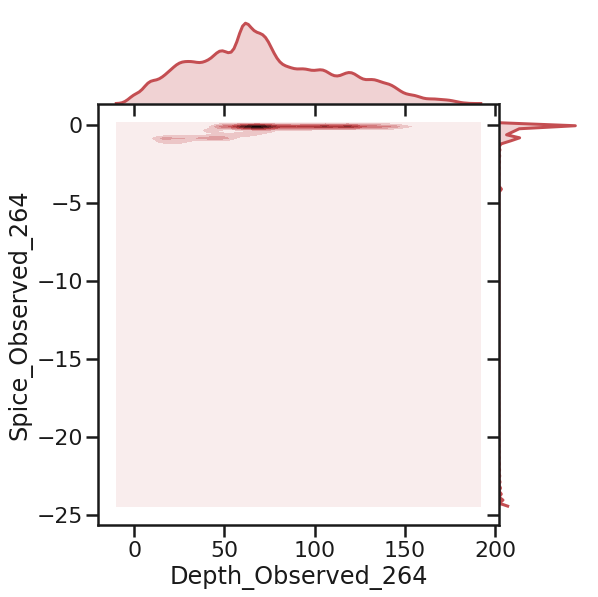

In [28]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Depth_Observed_264'] = depth_rho_264_finite
df['Spice_Observed_264'] = spic_rho_264_finite


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Spice_Observed_264", y="Depth_Observed_264", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

# q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [19]:
np.where(depth_rho_264_finite == np.min(depth_rho_264_finite))

(array([ 67558,  85234,  94778, 113924, 123665, 125983, 126539, 135726,
        137233, 149085, 156525, 157705, 189103, 198152, 234810, 245427]),)

In [ ]:
spic_rho_263_finite_final = spic_rho_263_finite[spic_rho_263_finite>-10]
model_263                 = model_263[spic_rho_263_finite>-10]


spic_rho_263_final = spic_rho_263_finite_final[spic_rho_263_finite_final>-2]
model_263          = model_263[spic_rho_263_finite_final>-2]

In [67]:
sns.set()

In [31]:
sns.set_style('darkgrid')
sns.set_context('talk')

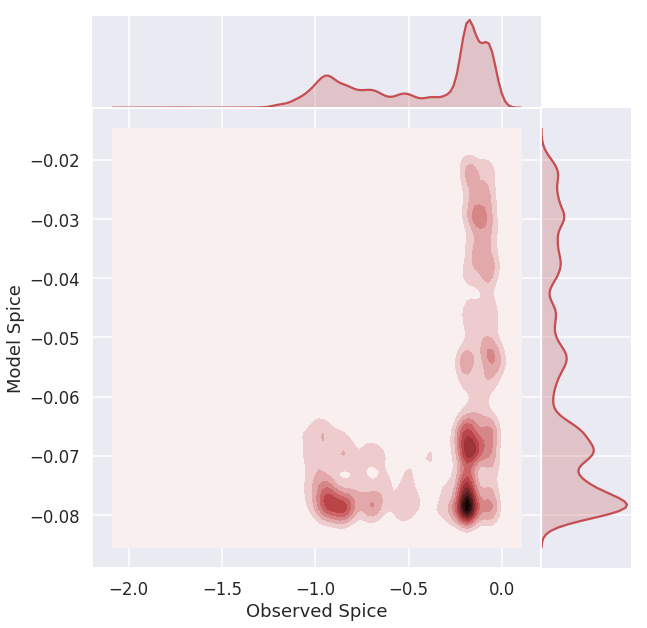

In [74]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_263_final
df['Model Spice'] = model_263


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [43]:
spic_rho_264_finite_final = spic_rho_264_finite[spic_rho_264_finite>-10]
model_264_finitte_final   = model_264[spic_rho_264_finite>-10]


spic_rho_264_final = spic_rho_264_finite_final[spic_rho_264_finite_final>-2]
model_264_final    = model_264_finitte_final[spic_rho_264_finite_final>-2]

In [11]:
model_264.shape

(279330,)

In [12]:
lat_location.shape

(405285,)

In [32]:
lat_location_actual = lat_location[~(np.isnan(y) & np.isnan(x))]
lon_location_actual = lon_location[~(np.isnan(y) & np.isnan(x))]

In [33]:
lat_location_actual.shape

(279330,)

In [34]:
spic_rho_negative_1     = spic_rho_264_finite[(spic_rho_264_finite>-1.1) & (spic_rho_264_finite<-0.9)]
lat_location_negative_1 = lat_location_actual[(spic_rho_264_finite>-1.1) & (spic_rho_264_finite<-0.9)]
lon_location_negative_1 = lon_location_actual[(spic_rho_264_finite>-1.1) & (spic_rho_264_finite<-0.9)]

depth_rho_264_negative_1 = depth_rho_264_finite[(spic_rho_264_finite>-1.1) & (spic_rho_264_finite<-0.9)]

In [39]:
np.mean(depth_rho_264_negative_1)

29.60385596437218

In [40]:
np.max(depth_rho_264_negative_1)

56.133000000000003

In [41]:
np.min(depth_rho_264_negative_1)

0.0

In [19]:
lon_location_negative_1.shape

(33457,)

In [38]:
np.max(depth_rho_264_negative_1)

56.133000000000003

In [14]:
y_new

array([  0.,   0.,   0., ...,  40.,  40.,  40.])

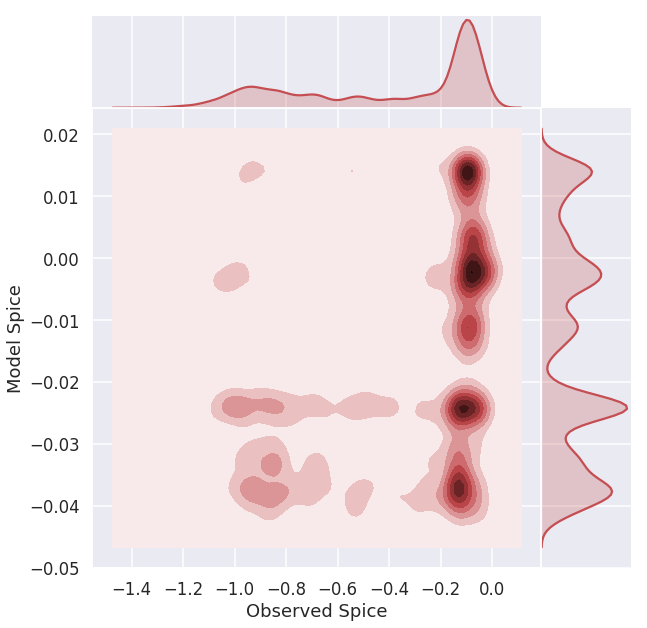

In [36]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_264_final
df['Model Spice'] = model_264_final


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [45]:
spic_rho_264_final_zoom = spic_rho_264_final[(spic_rho_264_final<0) &(spic_rho_264_final>-0.2)]
model_264_final_zoom    = model_264_final[(spic_rho_264_final<0) &(spic_rho_264_final>-0.2)]

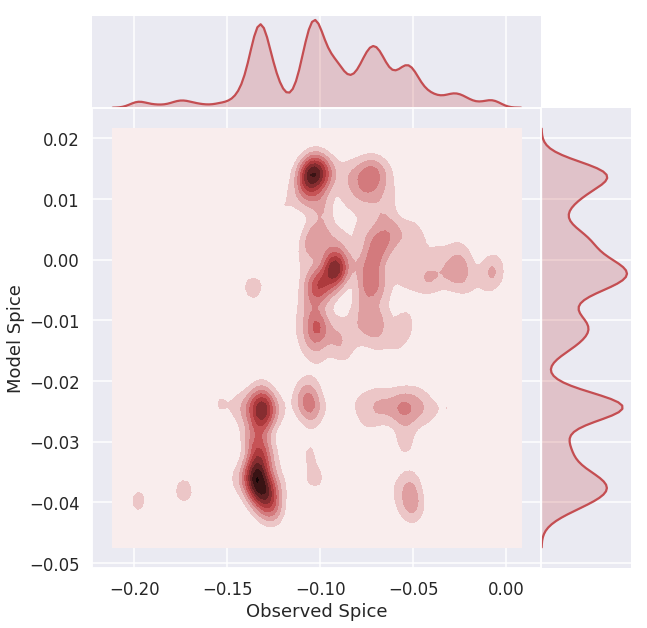

In [45]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_264_final_zoom
df['Model Spice'] = model_264_final_zoom


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




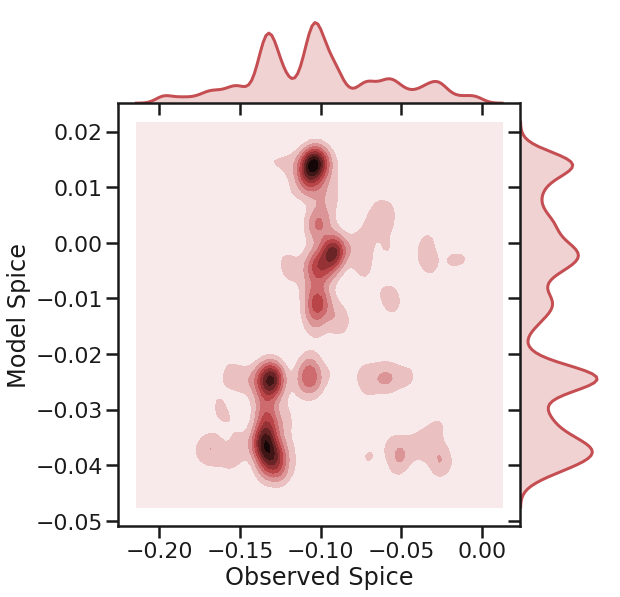

In [46]:
# SCIPY




df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_264_final_zoom
df['Model Spice'] = model_264_final_zoom


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [84]:
spic_rho_265_finite_final = spic_rho_265_finite[spic_rho_265_finite>-10]
model_265                 = model_265[spic_rho_265_finite>-10]


spic_rho_265_final = spic_rho_265_finite_final[spic_rho_265_finite_final>-2]
model_265          = model_265[spic_rho_265_finite_final>-2]

In [80]:

spic_rho_265_final_final = spic_rho_265_final[spic_rho_265_final>-0.2]
model_265          = model_265[spic_rho_265_final>-0.2]

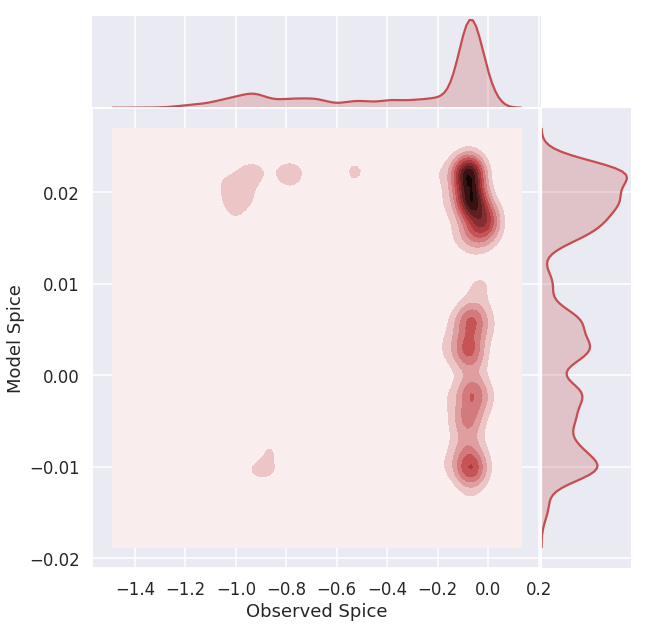

In [85]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_265_final
df['Model Spice'] = model_265


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [44]:
spic_rho_263.shape

(405285,)

In [57]:
model_263.shape

(279330,)

/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


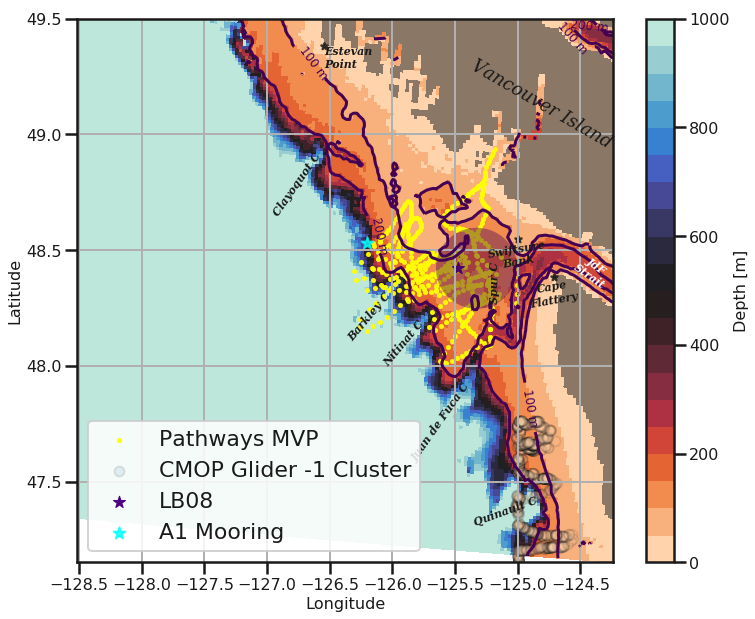

In [37]:
import matplotlib as mpl
# y = np.empty_like(lat_location)
# x = np.empty_like(lat_location)



cmap = plt.cm.get_cmap('icefire_r', 20)
# cmap = cmo.cm.turbid
# cmap = plt.cm.jet
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist[0] = (.8, .8, .8, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)
# cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()

ax.set_aspect(viz_tools.set_aspect(ax, coords='map', lats=lat_wcvi, adjustable='box-forced'))


# ax.relim()
# ax.autoscale_view(True,True,True)
# ax.autoscale_view(scalex=True)
# ax.autoscale(enable=True, axis='both', tight=None)
# bathy_tools.plot_colourmesh(bathy, title = 'WCVI Subset', fig_size=(9, 9), axis_limits=None, colour_map='winter_r', bins=15, land_colour='burlywood')
# p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=500)


p = ax.pcolormesh(lon_wcvi,lat_wcvi,Z, cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(p, ax=ax)
ax.set_aspect('auto')



CS1 = ax.contour(lon_wcvi, lat_wcvi, Z, np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(1000,1010,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(500,510,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



# aspect = 20
# pad_fraction = 0.001
# divider = make_axes_locatable(ax)
# width = axes_size.AxesY(ax, aspect=1./aspect)
# pad = axes_size.Fraction(pad_fraction, width)
# cax = divider.append_axes("right", size=width, pad=pad)
# cbar = fig.colorbar(p, cax=cax)


# for i in np.arange(lat_location.shape[0]):
#     y[i], x[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
# n = np.empty_like(lat_location)
# m = np.empty_like(lat_location)


# for i in np.arange(lat_location.shape[0]):
#     n[i], m[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

# y = y.astype(int)
# x = x.astype(int)

# n = n.astype(int)
# m = m.astype(int)
# ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.5, label = 'Falkor CTD locations')

ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

lon_W02 = -124.89500
lat_W02 = 48.04167

lon_W01 = -124.82500
lat_W01 = 48.31500



lon_swift = -125.00
lat_swift = 48.55

ax.scatter(lon_swift, lat_swift,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Swiftsure Bank')

# S = ("SwB")
S = ("Swiftsure\nBank")
ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)
# ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 10,
#          va='bottom', wrap=False)


lat_cape = 48.3831
lon_cape = -124.7144

ax.scatter(lon_cape, lat_cape,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Cape Flattery')

CP = ("Cape\nFlattery")
ax.text(lon_cape, lat_cape, CP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)


lat_jdfs = 48.5
lon_jdfs = -124.4

JD = ("JdF\nStrait")
ax.text(lon_jdfs, lat_jdfs, JD, fontsize=11, color = 'white', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = -35,
         va='top', wrap=False)


lat_EP = 49.3835
lon_EP = -126.5447

ax.scatter(lon_EP, lat_EP,  c='k', marker='*',  s=50, alpha=0.8)

EP = ("Estevan\nPoint")
ax.text(lon_EP, lat_EP, EP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 0,
         va='top', wrap=False)


lon_LB08 = -125.4775
lat_LB08 = 48.4217




ax.scatter(lon_falkor[::3], lat_falkor[::3],  c='yellow', marker='o',  s=10, alpha=0.9, label = 'Pathways MVP')

ax.scatter(lon_location_negative_1[::50], lat_location_negative_1[::50],  c=depth_rho_264_negative_1[::50], cmap= cmap, vmin = 0, vmax = 1000, marker='o',\
           s=100,edgecolors = 'k',  alpha=0.1, label = 'CMOP Glider -1 Cluster')

ax.scatter(lon_LB08, lat_LB08,  c='indigo', marker='*',  s=150, linewidths=1.2, alpha=1, label = 'LB08')

lon_A1 = -126.20433
lat_A1 = 48.52958

ax.scatter(lon_A1, lat_A1,  c='cyan',marker='*',  s=150, alpha=0.8, label = 'A1 Mooring')

# ax.scatter(lon_W01, lat_W01, c='cyan', s=150, alpha=0.8, label = 'W01')

# ax.scatter(lon_W02, lat_W02, c='red', s=150, alpha=0.8, label = 'W02')

# ax.scatter(lon_location[:], lat_location[:], c='purple', s=100, alpha=0.3, label = 'Falkor CTD locations')

legend = ax.legend(loc='lower left', fancybox=True, framealpha=0.85)

# ax.set_xlabel('x_index')
# ax.set_ylabel('y_index')
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

# viz_tools.plot_land_mask(ax, bathy)#, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
# cbar = fig.colorbar(p, cax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=16)
ax.tick_params(axis='both',labelsize =16)
cbar.ax.tick_params(labelsize=16) 

# t = ("JdF Canyon")
# ax.text(lon_W01, lat_W01, t, fontsize=11, color = 'darkblue', family='serif', style='italic', ha='left', rotation = 55,
#          va='bottom', wrap=True)

t = ("Juan de Fuca C")
ax.text(-125.79, 47.58, t, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)



d = ("Clayoquot C")
ax.text( -126.9, 48.64, d, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)

C = ("Spur C")
ax.text(-125.14, 48.45, C, fontsize=11, color = 'k',fontweight = 'heavy', family='serif', style='italic', ha='right', rotation = 90,
         va='bottom', wrap=True)

X = ("Barkley C")
ax.text(-126.0, 48.3, X, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)

Y = ("Nitinat C")
ax.text(-125.73, 48.18, Y, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)


A = ("Quinault C")
ax.text(-124.83, 47.4, A, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 20,
         va='bottom', wrap=True)


V = ("Vancouver Island")
ax.text(-124.85, 49.1, V, fontsize=18, color = 'k', family='serif', style='italic', ha='center', rotation = -30,
         va='bottom', wrap=True)

from matplotlib.patches import Circle,Ellipse
from matplotlib.collections import PatchCollection


patches = []
# circle = Circle((lon_LB08, lat_LB08), 0.35)
# circle = plt.Circle((lon_LB08, lat_LB08), 0.2, color='blue')
circle = Ellipse((lon_LB08+0.15, lat_LB08), 0.65, 0.35,
                     angle=0, linewidth=2, fill=False, zorder=2, label = 'Eddy Region')
patches.append(circle)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)

ax.grid()






ax.set_ylim(top=49.5, bottom=47.15136337)
ax.set_xlim(left=-128.51552, right=-124.24068451)

path_to_save = '/home/ssahu/saurav/NEP36_Model_Eval_plots/'
# plt.savefig(path_to_save + 'Domain_edited.png')

In [63]:
np.nanmean(model_263)

-0.059565421

In [66]:
np.min(spic_rho_263_finite_final)

-6.09829404291564

In [48]:
x_new.shape

(279330,)

In [32]:
y.shape

(405285,)

In [45]:
spic_rho_263_finite.shape

(279330,)

In [20]:
model_rho_264.shape

(170, 170)

In [21]:
lat_wcvi.shape

(170, 170)

In [41]:
depth_rho_264_negative_1

array([ 53.151,  53.151,  53.151, ...,  39.072,  39.072,  39.072])

In [11]:
f[:2]

[1, 2]

In [104]:
spic_position.shape

(146,)

In [105]:
lon_position

-124.762

In [40]:
trial  = np.array(dg.loc[46.908,-124.740].iloc[:,0])

In [42]:
trial


array([ 10.837,  10.837,  10.836,  10.838,  10.836,  10.838,  10.836,
        10.838,  10.839,  10.839,  10.839,  10.839,  10.842,  10.841,
        10.839,  10.836,  10.836,  10.836,  10.838,  10.839,  10.838,
        10.836,  10.836,  10.836,  10.836,  10.835,  10.837,  10.837,
        10.835,  10.834,  10.833,  10.835,  10.832,  10.821,  10.836,
        10.816,  10.811,  10.811,  10.82 ,  10.813,  10.795,  10.792,
        10.786,  10.786,  10.77 ,  10.75 ])

In [62]:
dg.index[:][0][0]

46.905000000000001

In [86]:
dg.index[405284][0]

47.761000000000003

In [87]:
dg.index[405284][1]

-124.95

In [23]:
def add_model_MVP_data(survey_file, iso_level, survey_iso_spic, model_spic):
    
    mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic


import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):

        self.sg.fig.set_size_inches(self.fig.get_size_inches())




/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [15]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [18]:
sns.set()

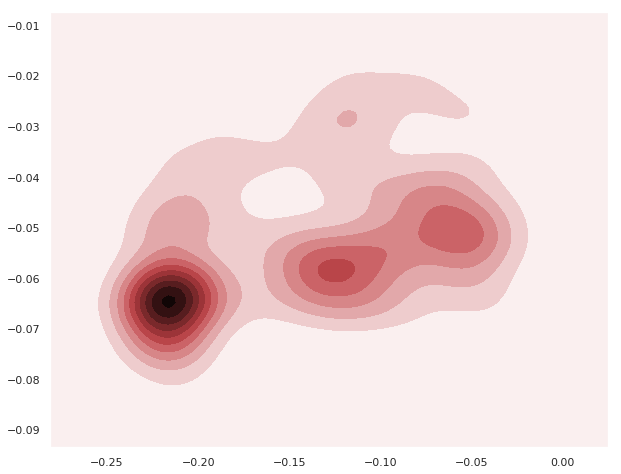

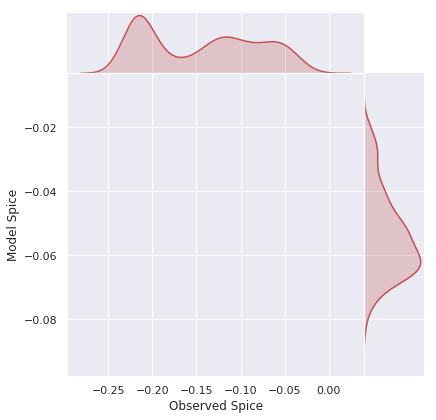

In [24]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, ax = ax, legend='brief', kind="kde", space=0, color="r", sizes=(1,10),stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# fig = q.fig
# fig.set_figwidth(10)
# fig.set_figheight(10)




In [ ]:
### Take the average of the model data for that month and then come up with the along iso-pycnal analysis